# **Task #1 ML**

#### ***Made by Elizabeth Granda***

For this task, a Machine Learning model will be developed using the linear regression methods covered, with a database containing house sale prices in Ames, United States. The goal is to predict these prices through the model we implement.

[Dataset Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code)

In this work, only the `train.csv` dataset included in the data downloaded from the web was used.


## **Exploratory Data Analysis**

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import spearmanr
sns.set()

In [ ]:
data = pd.read_csv('train.csv')
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.shape #tamaño del dataset

(1460, 81)

We fixed the column names in the data by removing whitespace and adding underscores.


In [ ]:
data.columns=data.columns.str.strip().str.lower().str.replace(" ", "_")
string_type_cols = data.dtypes[data.dtypes == "object"].index.tolist()
for col in string_type_cols:
  data[col] = data[col].str.strip().str.lower().str.replace(" ", "_")

In [ ]:
# conteo de valores nulos > 0
nan_values = data.isna().sum()
columns_with_nans = nan_values[nan_values > 0]
columns_with_nans

,0
lotfrontage,259
alley,1369
masvnrtype,872
masvnrarea,8
bsmtqual,37
bsmtcond,37
bsmtexposure,38
bsmtfintype1,37
bsmtfintype2,38
electrical,1


In [ ]:
# buscando duplicados
data.loc[data.duplicated()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice


<Axes: xlabel='saleprice', ylabel='Count'>

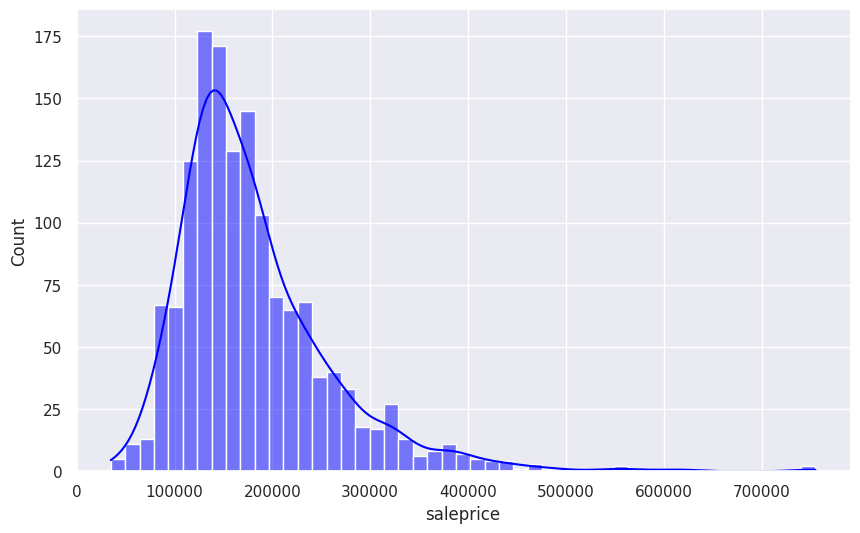

In [ ]:
# Distribucion de la variable target SalePrice
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data['saleprice'], kde=True, ax=ax, color='blue')

### **Behaviors of Some Categorical Variables with Respect to House Price**


<Axes: xlabel='mszoning', ylabel='saleprice'>

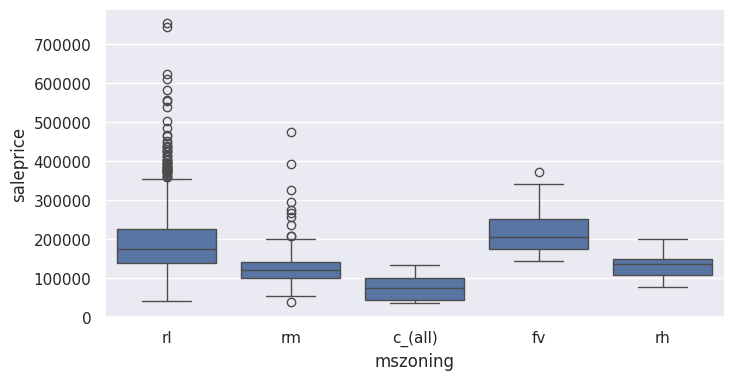

In [ ]:
#Precio de venta promedio vs la zona
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='mszoning', y='saleprice', data=data, ax=ax)

* RL: Residential Low Density  
* RM: Residential Medium Density  

A significant number of people don't mind paying more to live a bit farther from the population.

---

How is Lot Configuration related to the sale price?


In [ ]:
noise = data["lotconfig"].value_counts()
noise

,count
lotconfig,
inside,1052
corner,263
culdsac,94
fr2,47
fr3,4


Average house price by configuration: `Inside` is the most purchased house configuration, and it is also, on average, the cheapest compared to the others.


In [ ]:
data.groupby("lotconfig")["saleprice"].mean()

,saleprice
lotconfig,
corner,181623.425856
culdsac,223854.617021
fr2,177934.574468
fr3,208475.000000
inside,176938.047529


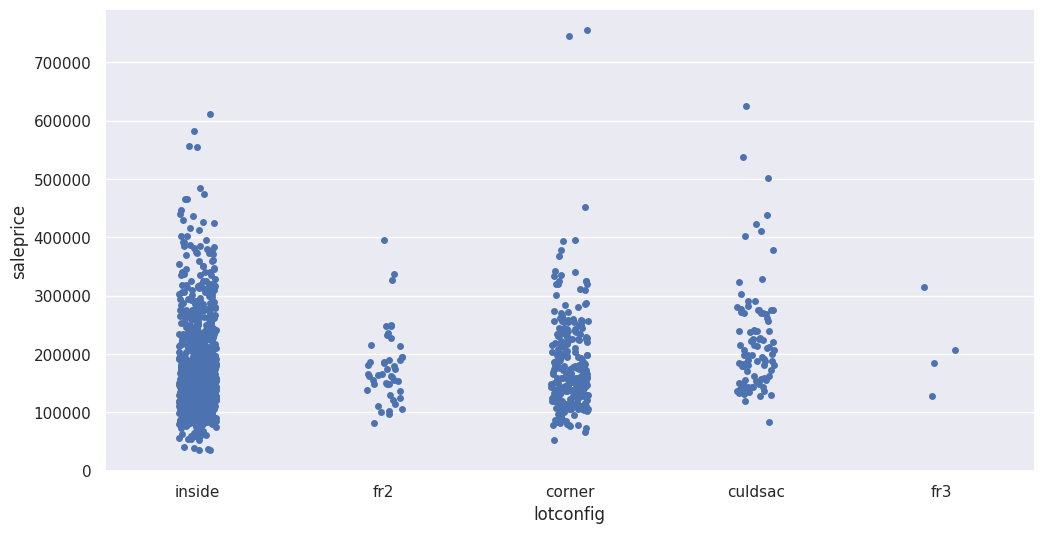

In [ ]:
# Precio general de cada uno de los tipos de configuracion de lote
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x='lotconfig', y='saleprice', data=data, ax=ax, jitter=True)
plt.show()

Behaviors by groups:

How many `LotConfig` are there in each neighborhood? With `Inside` being the most purchased, is there a preferred locality for these? `FR2` and `Inside` have fairly similar average prices, but the latter sells significantly more than the former.


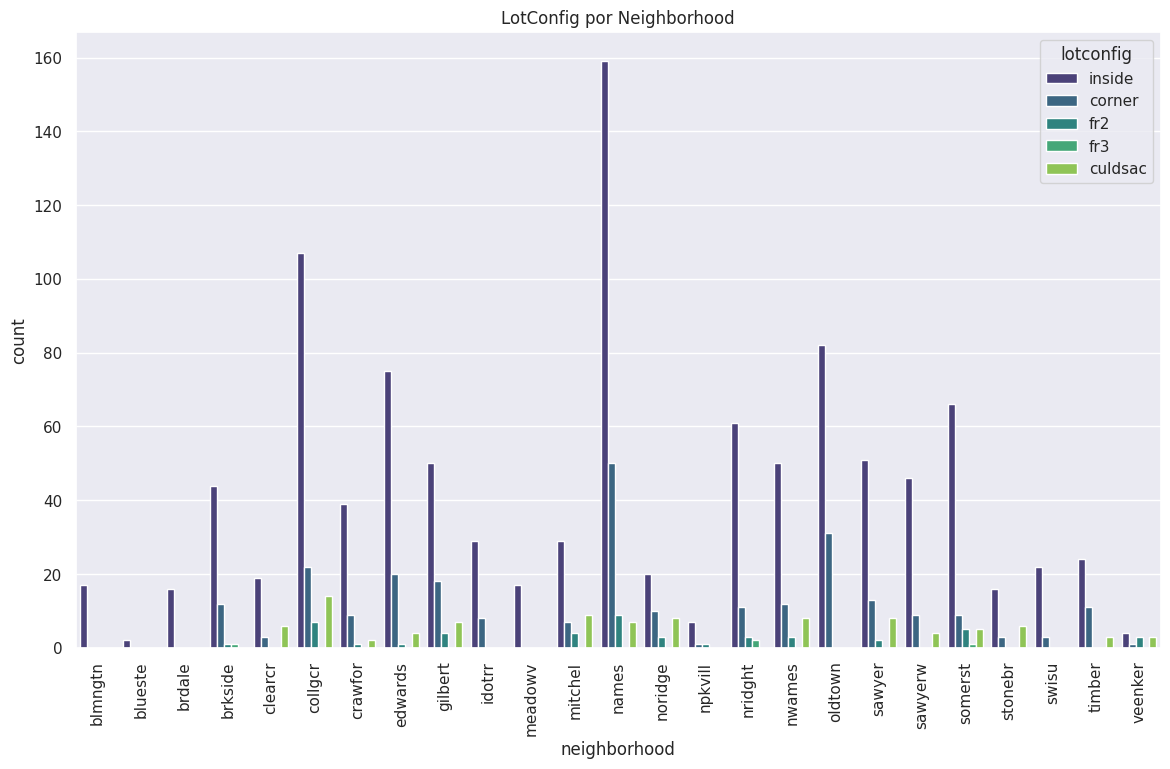

In [ ]:
config_in_neigh = data.groupby(["neighborhood", "lotconfig"]).size().reset_index(name='count')
plt.figure(figsize=(14, 8))
sns.barplot(x='neighborhood', y='count', hue='lotconfig', data=config_in_neigh, palette='viridis')
plt.xticks(rotation=90)
plt.title('LotConfig por Neighborhood')
plt.show()

Considering that most people settle in the North of Ames, `NAmes`, what is the price of houses there?


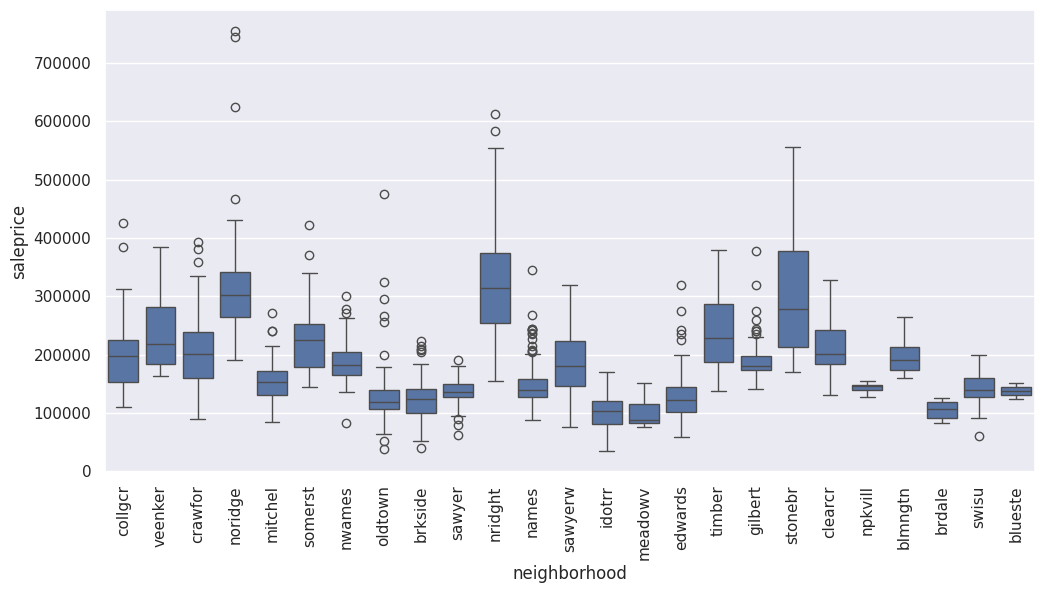

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='neighborhood', y='saleprice', data=data, ax=ax)
plt.xticks(rotation=90)
plt.show()

It can be seen that compared to the other neighborhoods, the North of Ames is, on average, cheaper than almost all the other neighborhoods. This chart also helps us see that neighborhoods play a fundamental role in pricing a house: it's not the same to buy a house in the North of Ames, which will cost on average $≈ 120-130k, as buying it in College Creek (`collgcr`), where it will cost on average twice as much as in the North of Ames.


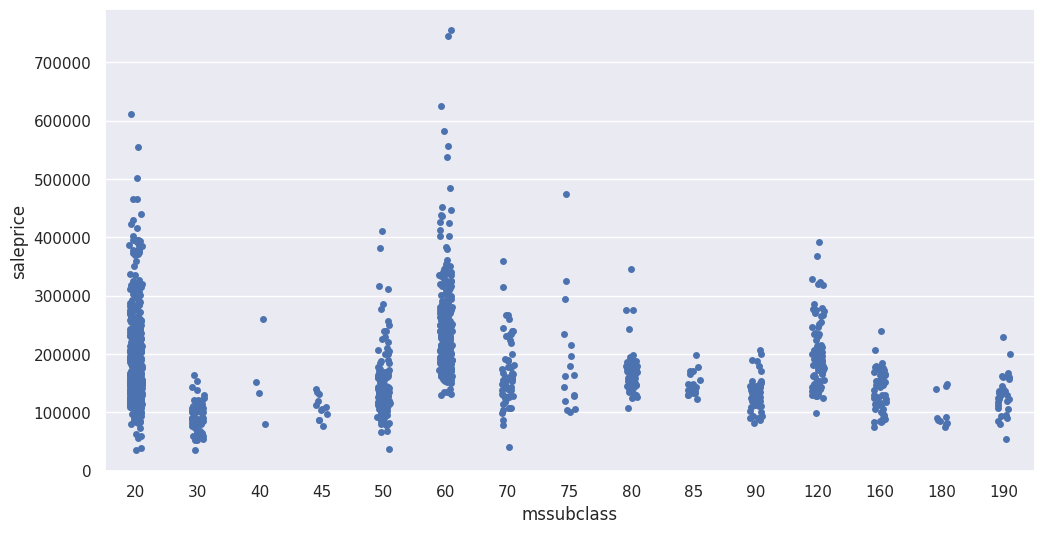

In [ ]:
# Tipo de vivienda vs el precio
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x='mssubclass', y='saleprice', data=data, ax=ax, jitter=True)
plt.show()


Compared to the others, the most sold house types are 20 and 60. These correspond to single-story houses built in 1946 or later, and two-story houses built in 1946 or later, respectively.


### **Behaviors of Numerical Variables with Respect to House Price**

To examine which variables might make a significant contribution to the model, a Pearson correlation matrix will be created to show direct and inverse relationships between the variables. This will be done for the numerical type features.



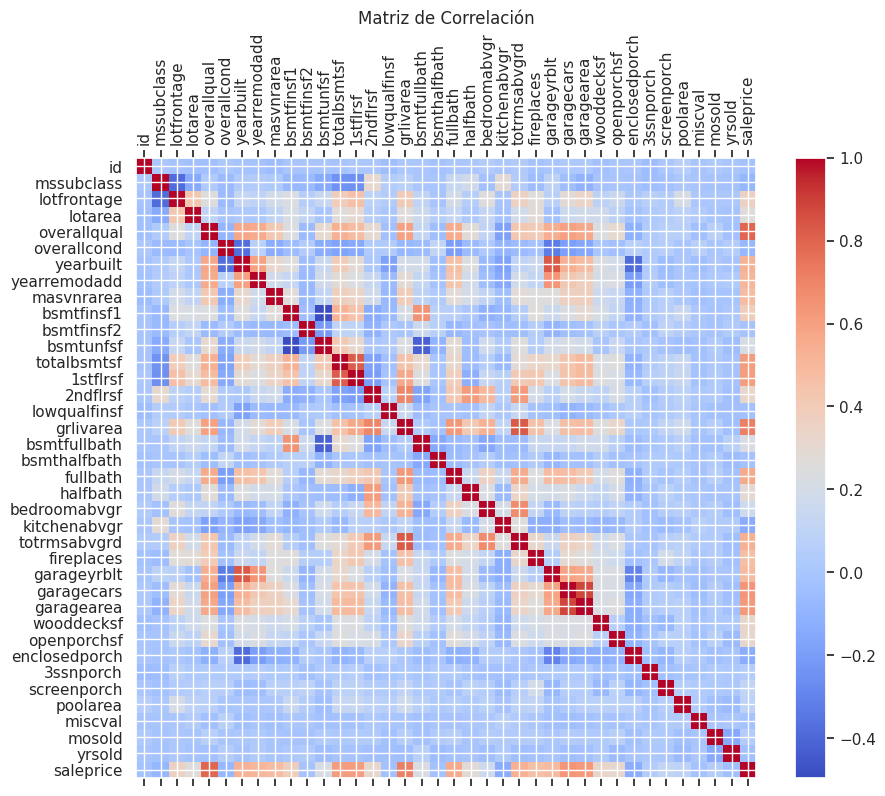

In [ ]:
numeric_data = data.select_dtypes(include=['number'])

if not numeric_data.empty:
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)

    plt.xticks(ticks=range(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=90)
    plt.yticks(ticks=range(len(correlation_matrix.columns)), labels=correlation_matrix.columns)

    plt.colorbar()
    plt.title('Matriz de Correlación')
    plt.show()
else:
    pass

Since `saleprice` is the last row and column of the correlation matrix, we can see that there are directly proportional relationships with other features. Later, we will use the information provided by this correlation matrix to discard and highlight features for the ML model.

The variables with which `saleprice` has a directly proportional relationship are:

`overallqual, grlivarea, garagecars, 1stflrsf, totalbsmtf, yearbuilt`

If we plot these against `saleprice`, what behavior would we observe?


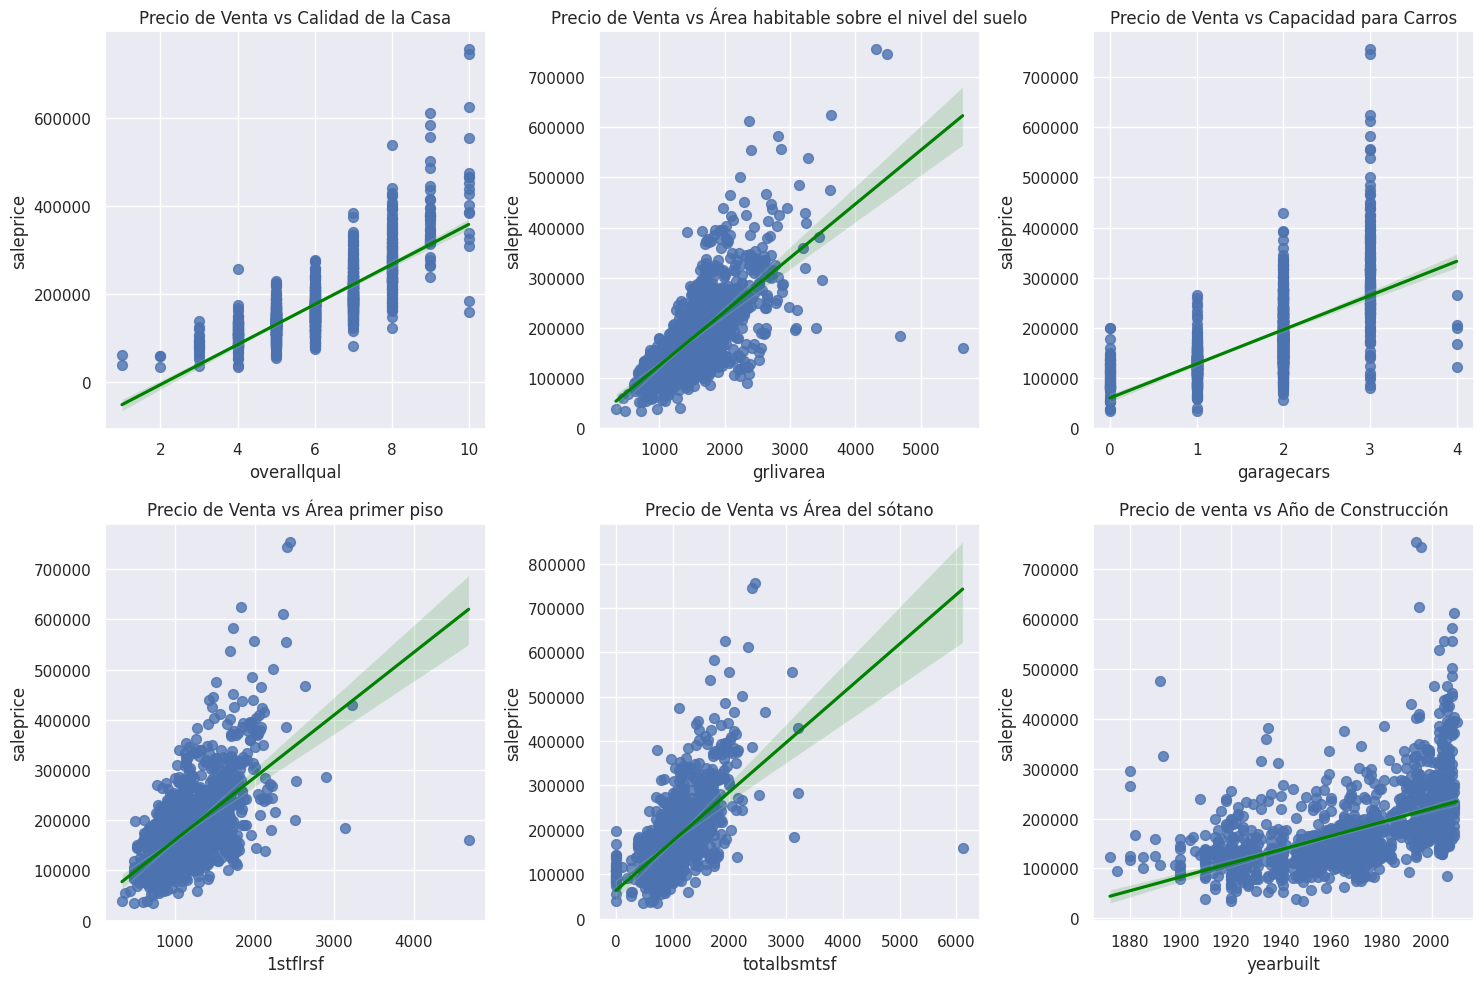

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.regplot(x="overallqual", y="saleprice", data=data, ax=axs[0, 0], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[0, 0].set_title("Precio de Venta vs Calidad de la Casa")

sns.regplot(x="grlivarea", y="saleprice", data=data, ax=axs[0, 1], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[0, 1].set_title("Precio de Venta vs Área habitable sobre el nivel del suelo")

sns.regplot(x="garagecars", y="saleprice", data=data, ax=axs[0, 2], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[0, 2].set_title("Precio de Venta vs Capacidad para Carros")

sns.regplot(x="1stflrsf", y="saleprice", data=data, ax=axs[1, 0], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[1, 0].set_title("Precio de Venta vs Área primer piso")

sns.regplot(x="totalbsmtsf", y="saleprice", data=data, ax=axs[1, 1], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[1, 1].set_title("Precio de Venta vs Área del sótano")

sns.regplot(x="yearbuilt", y="saleprice", data=data, ax=axs[1, 2], scatter_kws={'s':50}, line_kws={'color':'green'})
axs[1, 2].set_title("Precio de venta vs Año de Construcción")

plt.tight_layout()
plt.show()

As we can see, these variables follow a linear behavior with respect to the house price.


## **Starting the Model**

First, the data is split using the `scikit-learn` function seen in class.


In [ ]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
len(df_train), len(df_val), len(df_test)

(876, 292, 292)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

The target variable data will be rescaled since, considering that prices will be compared in thousands of dollars (quite high, in fact) with, for example, numbers of bathrooms, or areas in square feet, etc., to have a more proportional relationship, `saleprice` will be placed on a logarithmic scale.


In [ ]:
y_train = np.log1p(df_train.saleprice.values)
y_val = np.log1p(df_val.saleprice.values)
y_test = np.log1p(df_test.saleprice.values)

del df_train['saleprice']
del df_val['saleprice']
del df_test['saleprice']

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)

In [ ]:
#df_full_train['saleprice_transformed'] = np.log1p(df_full_train.saleprice)

In [ ]:
df_full_train

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,922,90,rl,67.0,8777,pave,NaN,reg,lvl,allpub,...,0,NaN,gdprv,NaN,0,9,2008,wd,normal,145900
1,521,190,rl,60.0,10800,pave,grvl,reg,lvl,allpub,...,0,NaN,NaN,NaN,0,8,2008,wd,normal,106250
2,402,20,rl,65.0,8767,pave,NaN,ir1,lvl,allpub,...,0,NaN,NaN,NaN,0,7,2006,new,partial,164990
3,281,60,rl,82.0,11287,pave,NaN,reg,lvl,allpub,...,0,NaN,NaN,NaN,0,1,2007,wd,normal,228500
4,1402,60,rl,62.0,7415,pave,NaN,ir1,lvl,allpub,...,0,NaN,NaN,NaN,0,4,2008,wd,normal,193000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,716,20,rl,78.0,10140,pave,NaN,reg,lvl,allpub,...,0,NaN,mnprv,NaN,0,8,2009,wd,normal,165000
1164,906,20,rl,80.0,9920,pave,NaN,reg,lvl,allpub,...,0,NaN,mnprv,NaN,0,2,2010,wd,normal,128000
1165,1097,70,rm,60.0,6882,pave,NaN,reg,lvl,allpub,...,0,NaN,NaN,NaN,0,3,2007,wd,normal,127000
1166,236,160,rm,21.0,1680,pave,NaN,reg,lvl,allpub,...,0,NaN,NaN,NaN,0,8,2008,wd,normal,89500


Despues de separar los datos para el entrenamiento, el test y la validación del modelo, buscaremos entonces descartar algunas features que no servirán mucho para el modelo.

---

Existen $1460$ observaciones y $81$ features en el dataset. Con el conteo de datos nulos en el dataset que se hizo anteriormente, se puede observar que algunas de estas features son casi en su totalidad o el $80 \%$ de ellas, datos nulos, por lo que se llega a la conclusión de que en realidad éstas no tendrán ningún efecto/relación con respecto al precio de venta de la casa, por lo que las quitaremos del dataset y con esto eli`miscfeature`, `poolqc`, `alley`, `fence`, `masvnrtype`


---

By reading the `.txt` file that comes with the data, we can note that there are features that explain others; in these cases, we will remove the variables that can be explained by others. This is because combining variables that are strongly related to each other but not necessarily to the target variable will make the model fit the training data very well, but it will perform poorly when evaluated with new data. Therefore, to avoid correlation, some variables will be removed.

In the dataset, there are two variables called `garagequal` and `garagecond`, which are categorical variables providing information about the garage's quality and condition, respectively. These variables sound quite similar, so if we were to plot both:
minaremos un poco de ruido para un mejor análisis.

Se eliminarán por esta razón las siguientes features:

```
miscfeature, poolqc, alley, fence, masvnrtype
```
---
Leyendo el archivo `.txt` que viene con los datos, se puede notar que hay Features que explican otras; para esos casos eliminaremos entonces las variables que puedan explicarse con otras. Esto ya que juntar variables que estén fuertemente relacionadas entre ellas sin necesidad de estar relacionadas con la variable target, hará que el modelo se acomode muy bien a los datos de entrenamiento pero cuando se evalúe con nuevos será muy malo, por lo que para evitar correlación se quitarán algunas.

En el dataset existen dos variables llamadas `garagequal` y `garagecond` que son variables categóricas las cuales y brindan información sobre la calidad del garaje y la condición de este respectivamente. Estas variables suenan bastante parecidas, por lo que si graficáramos ambas:

<Axes: xlabel='garagecond', ylabel='count'>

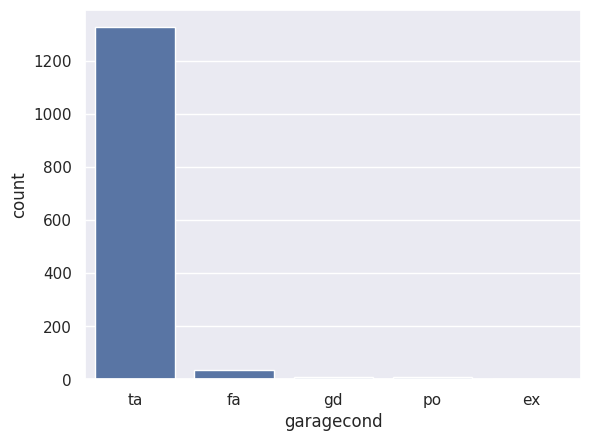

In [ ]:
sns.countplot(x='garagecond', data=data)

<Axes: xlabel='garagequal', ylabel='count'>

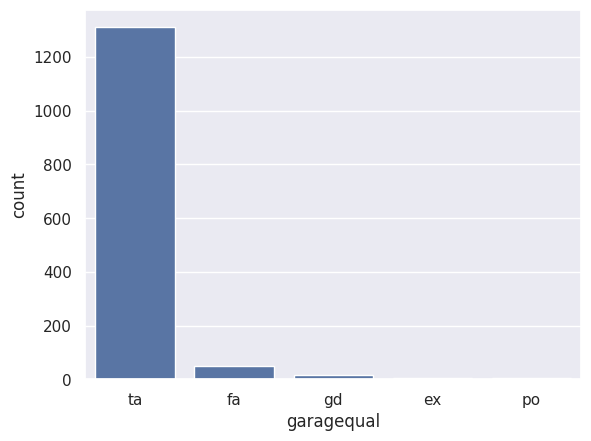

In [ ]:
sns.countplot(x='garagequal', data=data)

In other words, the information in one is also present in the other, so one of them could be removed from the dataset. This same behavior applies to the variables `bsmtqual` and `bsmtcond`. So:

* `garagequal` can provide the information from `garagecond`
* `bsmtqual` can provide the information from `bsmtcond`

Therefore, both will also be removed from the dataset.



In [ ]:
df_train = df_train.drop(columns=['miscfeature', 'miscval', 'poolqc', 'poolarea', 'alley', 'fence', 'garagecond', 'bsmtcond', 'masvnrtype',
                                  'bsmtfintype1', 'bsmtfintype2', 'id'], axis=1)

In addition to the 6 features we mentioned earlier that we will remove, `miscval` and `poolarea` were also removed, as the former represents the value of `miscfeature`, so if we remove it, the latter would lose all meaning.

The same applies to `poolarea` and `poolqc`: both can only be kept if the house has a pool, but since the data shows that most houses do not have one, both are removed.


In [ ]:
# Conteo de datos faltantes en el dataset de entrenamiento
df_train.isnull().sum().sort_values(ascending=False)

,0
fireplacequ,409
lotfrontage,163
garagetype,45
garageyrblt,45
garagefinish,45
...,...
bsmtfinsf2,0
bsmtunfsf,0
totalbsmtsf,0
heating,0


To build the ML model, all the missing values in the variables need to be filled. For this, we will first look at the variables at the top, read the `.txt` file to understand the context of each one, and determine what value could be used to fill them.

* For the `fireplacequal` variable, we know that it represents "the quality of the fireplace" and/or heating in the house. There are quite a few missing values here (almost half of the total training data); it is also indicated that a missing value means the absence of this feature in the house, which affects its price. Filling this categorical variable with the mode would slightly bias the house prices: houses without a fireplace are cheaper than others. Therefore, this variable will be filled with **`NA`**, so it is clear that this feature is absent.

* For the categorical variables, all missing values will be filled with the **mode** of each variable. (Except for the one mentioned earlier)

* For the missing values in the numerical variables, they will be filled with the mean of each variable.

* Similar to the above, the `garageyrblt` variable indicates the year the garage was built, which is related to the house price. Missing values in this numerical variable indicate the absence of a garage, so filling it with the "mean" would assume that the house has a garage, thus "creating" an incorrect price for the house: it would be assuming the house has a garage but would cost as if it were a house without a garage (much cheaper), which doesn't make sense. This variable will therefore be filled with zero.

---

After filling the missing values, we can proceed to perform **mutual_information** to identify which variables are most related to the house sale price, without requiring a linear relationship.


In [ ]:
def Prepare_Data(dataframe):
    if 'fireplacequ' in dataframe.columns:
        dataframe['fireplacequ'] = dataframe['fireplacequ'].fillna('NA')
    if 'garageyrblt' in dataframe.columns:
        dataframe['garageyrblt'] = dataframe['garageyrblt'].fillna(0)
        for col in dataframe.columns:
          if col not in ['fireplacequ', 'garageyrblt']:
            if dataframe[col].dtype == 'object':
                dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
            else:
                dataframe[col].fillna(dataframe[col].mean(), inplace=True)
    return dataframe

In [ ]:
# Limpiamos cada df
df_full_train = Prepare_Data(df_full_train)
df_train = Prepare_Data(df_train)
df_test = Prepare_Data(df_test)

### **Representativeness of Categorical Variables**


In [ ]:
string_type_cols = df_train.select_dtypes(include=['object'])
numerical_type_cols = df_train.select_dtypes(include=['number'])

In [ ]:
global_saleprice = data.saleprice.mean()
global_saleprice

180921.19589041095

In [ ]:
for c in string_type_cols.columns:
    print(c)
    df_group = data.groupby(c).saleprice.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_saleprice
    df_group['risk'] = df_group['mean'] / global_saleprice
    display(df_group)
    print()
    print()

mszoning


,mean,count,diff,risk
mszoning,,,,
c_(all),74528.000000,10,-106393.195890,0.411936
fv,214014.061538,65,33092.865648,1.182913
rh,131558.375000,16,-49362.820890,0.727158
rl,191004.994787,1151,10083.798897,1.055736
rm,126316.830275,218,-54604.365615,0.698187




street


,mean,count,diff,risk
street,,,,
grvl,130190.500000,6,-50730.695890,0.719598
pave,181130.538514,1454,209.342624,1.001157




lotshape


,mean,count,diff,risk
lotshape,,,,
ir1,206101.665289,484,25180.469399,1.139179
ir2,239833.365854,41,58912.169963,1.325623
ir3,216036.500000,10,35115.304110,1.194092
reg,164754.818378,925,-16166.377512,0.910644




landcontour


,mean,count,diff,risk
landcontour,,,,
bnk,143104.079365,63,-37817.116525,0.790975
hls,231533.940000,50,50612.744110,1.279750
low,203661.111111,36,22739.915221,1.125690
lvl,180183.746758,1311,-737.449132,0.995924




utilities


,mean,count,diff,risk
utilities,,,,
allpub,180950.95682,1459,29.760929,1.000164
nosewa,137500.00000,1,-43421.195890,0.759999




lotconfig


,mean,count,diff,risk
lotconfig,,,,
corner,181623.425856,263,702.229965,1.003881
culdsac,223854.617021,94,42933.421131,1.237305
fr2,177934.574468,47,-2986.621422,0.983492
fr3,208475.000000,4,27553.804110,1.152297
inside,176938.047529,1052,-3983.148362,0.977984




landslope


,mean,count,diff,risk
landslope,,,,
gtl,179956.799566,1382,-964.396325,0.994670
mod,196734.138462,65,15812.942571,1.087402
sev,204379.230769,13,23458.034879,1.129659




neighborhood


,mean,count,diff,risk
neighborhood,,,,
blmngtn,194870.882353,17,13949.686463,1.077104
blueste,137500.000000,2,-43421.195890,0.759999
brdale,104493.750000,16,-76427.445890,0.577565
brkside,124834.051724,58,-56087.144166,0.689991
clearcr,212565.428571,28,31644.232681,1.174906
collgcr,197965.773333,150,17044.577443,1.094210
crawfor,210624.725490,51,29703.529600,1.164179
edwards,128219.700000,100,-52701.495890,0.708705
gilbert,192854.506329,79,11933.310439,1.065959




condition1


,mean,count,diff,risk
condition1,,,,
artery,135091.666667,48,-45829.529224,0.746688
feedr,142475.481481,81,-38445.714409,0.787500
norm,184495.492063,1260,3574.296173,1.019756
posa,225875.000000,8,44953.804110,1.248472
posn,215184.210526,19,34263.014636,1.189381
rrae,138400.000000,11,-42521.195890,0.764974
rran,184396.615385,26,3475.419494,1.019210
rrne,190750.000000,2,9828.804110,1.054326
rrnn,212400.000000,5,31478.804110,1.173992




condition2


,mean,count,diff,risk
condition2,,,,
artery,106500.000000,2,-74421.195890,0.588654
feedr,121166.666667,6,-59754.529224,0.669721
norm,181169.405536,1445,248.209646,1.001372
posa,325000.000000,1,144078.804110,1.796362
posn,284875.000000,2,103953.804110,1.574581
rrae,190000.000000,1,9078.804110,1.050181
rran,136905.000000,1,-44016.195890,0.756711
rrnn,96750.000000,2,-84171.195890,0.534763




bldgtype


,mean,count,diff,risk
bldgtype,,,,
1fam,185763.807377,1220,4842.611487,1.026766
2fmcon,128432.258065,31,-52488.937826,0.709880
duplex,133541.076923,52,-47380.118967,0.738117
twnhs,135911.627907,43,-45009.567983,0.751220
twnhse,181959.342105,114,1038.146215,1.005738




housestyle


,mean,count,diff,risk
housestyle,,,,
1.5fin,143116.740260,154,-37804.455631,0.791045
1.5unf,110150.000000,14,-70771.195890,0.608829
1story,175985.477961,726,-4935.717929,0.972719
2.5fin,220000.000000,8,39078.804110,1.215999
2.5unf,157354.545455,11,-23566.650436,0.869741
2story,210051.764045,445,29130.568155,1.161012
sfoyer,135074.486486,37,-45846.709404,0.746593
slvl,166703.384615,65,-14217.811275,0.921414




roofstyle


,mean,count,diff,risk
roofstyle,,,,
flat,194690.000000,13,13768.804110,1.076104
gable,171483.956179,1141,-9437.239712,0.947838
gambrel,148909.090909,11,-32012.104981,0.823061
hip,218876.933566,286,37955.737676,1.209792
mansard,180568.428571,7,-352.767319,0.998050
shed,225000.000000,2,44078.804110,1.243635




roofmatl


,mean,count,diff,risk
roofmatl,,,,
clytile,160000.000000,1,-20921.195890,0.884363
compshg,179803.679219,1434,-1117.516671,0.993823
membran,241500.000000,1,60578.804110,1.334835
metal,180000.000000,1,-921.195890,0.994908
roll,137000.000000,1,-43921.195890,0.757236
tar&grv,185406.363636,11,4485.167746,1.024791
wdshake,241400.000000,5,60478.804110,1.334283
wdshngl,390250.000000,6,209328.804110,2.157016




exterior1st


,mean,count,diff,risk
exterior1st,,,,
asbshng,107385.550000,20,-73535.645890,0.593549
asphshn,100000.000000,1,-80921.195890,0.552727
brkcomm,71000.000000,2,-109921.195890,0.392436
brkface,194573.000000,50,13651.804110,1.075457
cblock,105000.000000,1,-75921.195890,0.580363
cemntbd,231690.655738,61,50769.459847,1.280616
hdboard,163077.450450,222,-17843.745440,0.901373
imstucc,262000.000000,1,81078.804110,1.448144
metalsd,149422.177273,220,-31499.018618,0.825896




exterior2nd


,mean,count,diff,risk
exterior2nd,,,,
asbshng,114060.550000,20,-66860.645890,0.630443
asphshn,138000.000000,3,-42921.195890,0.762763
brk_cmn,126714.285714,7,-54206.910176,0.700384
brkface,195818.000000,25,14896.804110,1.082339
cblock,105000.000000,1,-75921.195890,0.580363
cmentbd,230093.833333,60,49172.637443,1.271790
hdboard,167661.565217,207,-13259.630673,0.926710
imstucc,252070.000000,10,71148.804110,1.393259
metalsd,149803.172897,214,-31118.022993,0.828002




exterqual


,mean,count,diff,risk
exterqual,,,,
ex,367360.961538,52,186439.765648,2.030503
fa,87985.214286,14,-92935.981605,0.486318
gd,231633.510246,488,50712.314355,1.280301
ta,144341.313466,906,-36579.882425,0.797813




extercond


,mean,count,diff,risk
extercond,,,,
ex,201333.333333,3,20412.137443,1.112823
fa,102595.142857,28,-78326.053033,0.567071
gd,168897.568493,146,-12023.627397,0.933542
po,76500.000000,1,-104421.195890,0.422836
ta,184034.896256,1282,3113.700365,1.017210




foundation


,mean,count,diff,risk
foundation,,,,
brktil,132291.075342,146,-48630.120548,0.731208
cblock,149805.714511,634,-31115.481379,0.828016
pconc,225230.442040,647,44309.246150,1.244909
slab,107365.625000,24,-73555.570890,0.593439
stone,165959.166667,6,-14962.029224,0.917301
wood,185666.666667,3,4745.470776,1.026229




bsmtqual


,mean,count,diff,risk
bsmtqual,,,,
ex,327041.041322,121,146119.845432,1.807644
fa,115692.028571,35,-65229.167319,0.639461
gd,202688.478964,618,21767.283074,1.120314
ta,140759.818182,649,-40161.377709,0.778017




bsmtexposure


,mean,count,diff,risk
bsmtexposure,,,,
av,206643.420814,221,25722.224924,1.142174
gd,257689.805970,134,76768.610080,1.424321
mn,192789.657895,114,11868.462004,1.065600
no,165652.295908,953,-15268.899983,0.915605




heating


,mean,count,diff,risk
heating,,,,
floor,72500.000000,1,-108421.195890,0.400727
gasa,182021.195378,1428,1099.999488,1.006080
gasw,166632.166667,18,-14289.029224,0.921021
grav,75271.428571,7,-105649.767319,0.416045
othw,125750.000000,2,-55171.195890,0.695054
wall,92100.000000,4,-88821.195890,0.509061




heatingqc


,mean,count,diff,risk
heatingqc,,,,
ex,214914.429150,741,33993.233259,1.187890
fa,123919.489796,49,-57001.706094,0.684936
gd,156858.871369,241,-24062.324521,0.867001
po,87000.000000,1,-93921.195890,0.480872
ta,142362.876168,428,-38558.319722,0.786878




centralair


,mean,count,diff,risk
centralair,,,,
n,105264.073684,95,-75657.122206,0.581823
y,186186.709890,1365,5265.514000,1.029104




electrical


,mean,count,diff,risk
electrical,,,,
fusea,122196.893617,94,-58724.302273,0.675415
fusef,107675.444444,27,-73245.751446,0.595151
fusep,97333.333333,3,-83587.862557,0.537987
mix,67000.000000,1,-113921.195890,0.370327
sbrkr,186825.113193,1334,5903.917303,1.032633




kitchenqual


,mean,count,diff,risk
kitchenqual,,,,
ex,328554.670000,100,147633.474110,1.816010
fa,105565.205128,39,-75355.990762,0.583487
gd,212116.023891,586,31194.828000,1.172422
ta,139962.511565,735,-40958.684326,0.773610




functional


,mean,count,diff,risk
functional,,,,
maj1,153948.142857,14,-26973.053033,0.850913
maj2,85800.000000,5,-95121.195890,0.474240
min1,146385.483871,31,-34535.712019,0.809112
min2,144240.647059,34,-36680.548832,0.797257
mod,168393.333333,15,-12527.862557,0.930755
sev,129000.000000,1,-51921.195890,0.713018
typ,183429.147059,1360,2507.951168,1.013862




fireplacequ


,mean,count,diff,risk
fireplacequ,,,,
ex,337712.500000,24,156791.304110,1.866628
fa,167298.484848,33,-13622.711042,0.924704
gd,226351.415789,380,45430.219899,1.251105
po,129764.150000,20,-51157.045890,0.717241
ta,205723.488818,313,24802.292927,1.137089




garagetype


,mean,count,diff,risk
garagetype,,,,
2types,151283.333333,6,-29637.862557,0.836184
attchd,202892.656322,870,21971.460431,1.121442
basment,160570.684211,19,-20350.511680,0.887517
builtin,254751.738636,88,73830.542746,1.408081
carport,109962.111111,9,-70959.084779,0.607790
detchd,134091.162791,387,-46830.033100,0.741158




garagefinish


,mean,count,diff,risk
garagefinish,,,,
fin,240052.690341,352,59131.494450,1.326836
rfn,202068.869668,422,21147.673778,1.116889
unf,142156.423140,605,-38764.772750,0.785737




garagequal


,mean,count,diff,risk
garagequal,,,,
ex,241000.000000,3,60078.804110,1.332072
fa,123573.354167,48,-57347.841724,0.683023
gd,215860.714286,14,34939.518395,1.193120
po,100166.666667,3,-80754.529224,0.553648
ta,187489.836003,1311,6568.640113,1.036307




paveddrive


,mean,count,diff,risk
paveddrive,,,,
n,115039.122222,90,-65882.073668,0.635852
p,132330.000000,30,-48591.195890,0.731423
y,186433.973881,1340,5512.777990,1.030471




saletype


,mean,count,diff,risk
saletype,,,,
cod,143973.255814,43,-36947.940076,0.795779
con,269600.000000,2,88678.804110,1.490152
conld,138780.888889,9,-42140.307002,0.767079
conli,200390.000000,5,19468.804110,1.107609
conlw,143700.000000,5,-37221.195890,0.794268
cwd,210600.000000,4,29678.804110,1.164043
new,274945.418033,122,94024.222142,1.519697
oth,119850.000000,3,-61071.195890,0.662443
wd,173401.836622,1267,-7519.359268,0.958438




salecondition


,mean,count,diff,risk
salecondition,,,,
abnorml,146526.623762,101,-34394.572128,0.809892
adjland,104125.000000,4,-76796.195890,0.575527
alloca,167377.416667,12,-13543.779224,0.925140
family,149600.000000,20,-31321.195890,0.826879
normal,175202.219533,1198,-5718.976358,0.968390
partial,272291.752000,125,91370.556110,1.505030


This result allows us to see that there are variables that do not contribute much to the model, such as `utilities` and `street`, where more than 95% of the data has the same value. This tells us that these will not be decisive features when determining the price of a house.


And now, **Mutual Information**

In [ ]:
def mutual_info_saleprice_score(series):
    return mutual_info_score(series, df_full_train.saleprice)

In [ ]:
# Mutual information oara variables categoricas
mutual_info_obj = df_full_train[string_type_cols.columns].apply(mutual_info_saleprice_score)
mutual_info_obj.sort_values(ascending=False)

,0
neighborhood,2.079802
exterior2nd,1.249958
exterior1st,1.189382
fireplacequ,0.787360
housestyle,0.748184
garagefinish,0.695016
kitchenqual,0.694614
foundation,0.683389
bsmtqual,0.660063
heatingqc,0.631931


In [ ]:
# Mutual Information para variables numericas
mutual_info_num = df_full_train[numerical_type_cols.columns].apply(mutual_info_saleprice_score)
mutual_info_num.sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


,0
lotarea,5.551180
grlivarea,5.390426
1stflrsf,5.265998
totalbsmtsf,5.129668
bsmtunfsf,5.121870
garagearea,4.352501
bsmtfinsf1,3.968351
yearbuilt,3.335272
garageyrblt,3.216959
lotfrontage,2.860146


### **Feature Engineering**

Regarding the mutual information values of the categorical variables and the representativeness of these features from the previous code cell, we can now use some of these categorical variables for the model. Among the most important are `neighborhood`, `housestyle`, and `exterior2nd`, which had the highest mutual information scores. These represent the neighborhood of the house, the style of the house (based on its design, layout, and structure), and the exterior material of the house, respectively.

In addition, based on the information from the EDA, we can also consider the `lotconfig` variable, which describes the configuration type of the house and is related to both the neighborhood and the price of the house.

Since it is important to train the model with sufficient variables, we will also use other categorical variables, which we will mention later. The condition for selecting these will be that they are not highly correlated with each other.

---

To transform the `neighborhood`, `housestyle`, and `exterior2nd` variables into numerical values, we will group them based on the average price of the house in each category. Let's explain this approach for the case of neighborhoods:

There are 25 neighborhoods in the dataset, so we calculated the average price of houses in each neighborhood. Then, we assigned a group based on the price range: if the price was between $0$ and $100,000$, $100,000$ and $200,000$, and so on up to $760,000$, each neighborhood was assigned to one of five groups numbered from $0$ to $4$.

This same strategy was applied to the `housestyle` and `exterior2nd` variables.

Implementing this idea:


In [ ]:
def group_by_mean_and_bin(df, column_name, bins, labels):

    # Precio medio por categoria en la columna df_full_train
    mean_prices = df_full_train.groupby(column_name)['saleprice'].mean()

    groups = pd.cut(mean_prices, bins=bins, labels=labels)

    grouped_df = pd.DataFrame({
        column_name: mean_prices.index,
        f'average_saleprice_{column_name}': mean_prices.values,
        f'group_{column_name}': groups
    }).reset_index(drop=True)

    df = df.merge(grouped_df[[column_name, f'group_{column_name}']], on=column_name, how='left')

    return df

In [ ]:
bins = [0, 100000, 200000, 300000, 450000, 760000]
labels = [0, 1, 2, 3, 4]

# se aplica la función a df_train y df_val para las columnas 'neighborhood', 'exterior2nd', y 'housestyle'
df_train = group_by_mean_and_bin(df_train, 'neighborhood', bins, labels)
df_val = group_by_mean_and_bin(df_val, 'neighborhood', bins, labels)
df_test = group_by_mean_and_bin(df_test, 'neighborhood', bins, labels)

df_train = group_by_mean_and_bin(df_train, 'exterior2nd', bins, labels)
df_val = group_by_mean_and_bin(df_val, 'exterior2nd', bins, labels)
df_test = group_by_mean_and_bin(df_test, 'exterior2nd', bins, labels)

df_train = group_by_mean_and_bin(df_train, 'housestyle', bins, labels)
df_val = group_by_mean_and_bin(df_val, 'housestyle', bins, labels)
df_test = group_by_mean_and_bin(df_test, 'housestyle', bins, labels)

Si relizamos un conteo de los grupos por cada una de estas variables:

In [ ]:
df_train.group_neighborhood.value_counts()

,count
group_neighborhood,
1,628
2,136
3,85
0,27
4,0


In [ ]:
df_train.group_exterior2nd.value_counts()

,count
group_exterior2nd,
1,513
2,362
3,1
0,0
4,0


In [ ]:
df_train.group_housestyle.value_counts()

,count
group_housestyle,
1,592
2,284
0,0
3,0
4,0


For the variables `mszoning, lotshape, landcontour, landslope, condition1, bldgtype, roofstyle, roofmatl, exterior1st, exterqual, extercond, foundation, bsmtqual, bsmtexposure, heatingqc, centralair, electrical, functional, garagequal, paveddrive`, we will use the `LabelEncoder` function from scikit-learn.

A total of 20 categorical variables (plus the 3 previously mentioned) from the 43 in the dataset are being used. Some are being discarded because they are highly correlated with other variables, while others are excluded because, based on the context provided by the `.txt` file for each feature and by plotting each against `saleprice`, it was observed that they had little relationship or behavior patterns related to it. These variables are left out to avoid adding noise to the model.




In [ ]:
encoder = LabelEncoder()

In [ ]:
categorical_columns = df_train.select_dtypes(include=['object']).columns
categorical_columns_test = df_test.select_dtypes(include=['object']).columns
categorical_columns_val = df_val.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df_train[column] = encoder.fit_transform(df_train[column])


for column in categorical_columns_val:
    df_val[column] = encoder.fit_transform(df_val[column])


for column in categorical_columns_test:
    df_test[column] = encoder.fit_transform(df_test[column])

Now, for the numerical variables, we will use those with the highest mutual information scores, while excluding those that are highly correlated with other variables. Additionally, we will leave out the last six variables from the mutual information results, as their scores are significantly lower compared to the others retained for the model.

Correlation behavior was observed, for example, with the variables `bsmtunfsf` and `totalbsmtsf`, so only `bsmtunfsf` was kept. Similarly, for the variables `garagecars` and `garagearea`, only `garagearea` was kept. To confirm this, let's observe a plot of these two variables:


<Axes: xlabel='bsmtunfsf', ylabel='totalbsmtsf'>

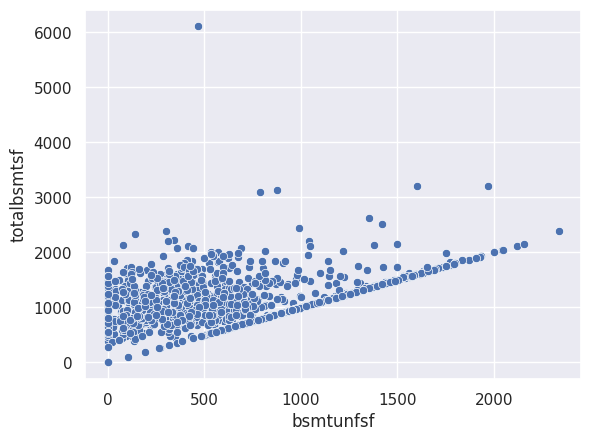

In [ ]:
sns.scatterplot(x="bsmtunfsf", y="totalbsmtsf", data=data)

<Axes: xlabel='garagecars', ylabel='garagearea'>

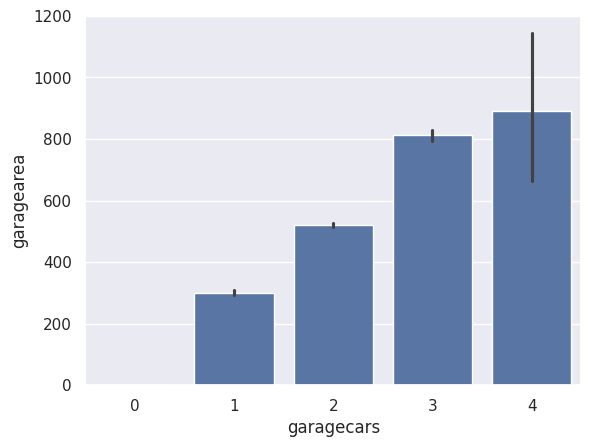

In [ ]:
sns.barplot(x="garagecars", y="garagearea", data=data)

### **Model Implementation**

For the selected variables, a Pearson correlation matrix will be created to avoid redundancy. As mentioned earlier, these correlations could lead to a very good fit between the prediction data and the training data. However, when compared with the test data and/or new data, the model will not perform well or adjust correctly.


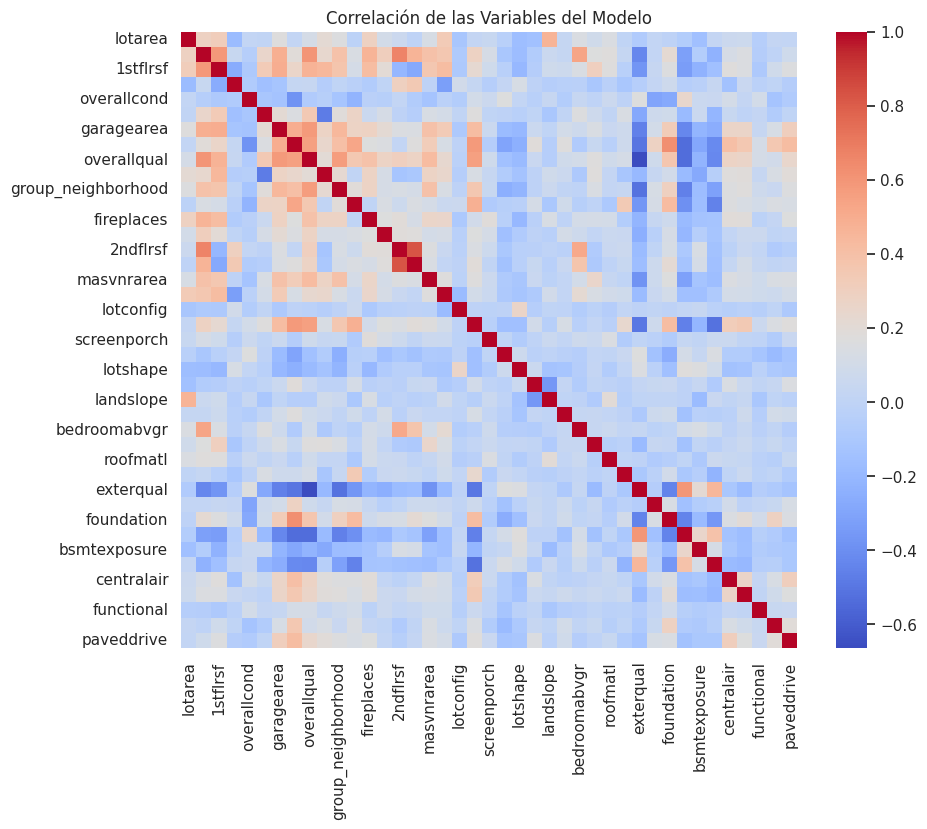

In [ ]:
selected_columns = ["lotarea", "grlivarea", "1stflrsf", "mssubclass", "overallcond",
                    "bsmtunfsf", "garagearea", "yearbuilt", "overallqual", "bsmtfinsf1" ,"group_neighborhood",
                    "group_exterior2nd", "fireplaces", "openporchsf", "2ndflrsf",
                    "group_housestyle", "masvnrarea", "lotfrontage", "lotconfig", "yearremodadd", "screenporch",
                    'mszoning', 'lotshape', 'landcontour', 'landslope', 'condition1', "bedroomabvgr",
                    'roofstyle', 'roofmatl', 'exterior1st','exterqual', 'extercond', 'foundation',
                    'bsmtqual', 'bsmtexposure','heatingqc', 'centralair', 'electrical',
                    'functional', 'garagequal', 'paveddrive']

df_selected = df_train[selected_columns]
corr_matrix = df_selected.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title('Correlación de las Variables del Modelo')
plt.show()

In [ ]:
len(selected_columns) # numero de features que trabajaremos

41

In [ ]:
X_test = df_test[selected_columns]
X_test = Prepare_Data(X_test)

In [ ]:
%%capture
X_train_ = df_train[selected_columns]
X_val = Prepare_Data(df_val[selected_columns])
X_val.lotfrontage = X_val.lotfrontage.fillna(X_val.lotfrontage.mean())
X_val.masvnrarea = X_val.masvnrarea.fillna(X_val.masvnrarea.mean())

#### **Testing with Regularization using Ridge:**


In [ ]:
print("**********Scores y resultados para Regularización de Ridge**********")
ridge = Ridge(alpha=10).fit(X_train_, y_train) # mejor alpha escogido en la parte de abajo
print("Training set score: {:.2f}".format(ridge.score(X_train_, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ridge.score(X_val, y_val)))

# la prediccionn
y_pred_ridge_ = ridge.predict(X_train_)

**********Scores y resultados para Regularización de Ridge**********
Training set score: 0.87
Test set score: 0.84
Validation set score: 0.88


##### **Hyperparameter Tuning: Ridge**

For this case, 21 values will be tested ranging from $10^{-15}$ to $10^{5}$, and 10-fold cross-validation will be performed to ensure that the best $\alpha$ is selected.


In [ ]:
# Realizando Hyperparameter Tunning
hyperParameters = {'alpha': np.logspace(-15, 5, num=21)}
ridgeRegressor = GridSearchCV(ridge, hyperParameters, scoring='neg_mean_squared_error', cv=10)
ridgeRegressor.fit(X_train_,y_train)

GridSearchCV(cv=10, estimator=Ridge(alpha=10),
             param_grid={'alpha': array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])},
             scoring='neg_mean_squared_error')

In [ ]:
print("Best value for lambda : ", ridgeRegressor.best_params_)

Best value for lambda :  {'alpha': 10.0}


(This value of $\alpha$ was set at the top within the Ridge model.)


To compare with the validation data, we will use what was covered in the class where the comparison between validation and training was done using the coefficients and the intercept obtained from the Ridge model for our data:


In [ ]:
y_pred_ridge = ridge.intercept_ + X_val.dot(ridge.coef_)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_ridge ) )}" )
print(f"MAPE: {np.mean(np.abs((y_val - y_pred_ridge) / y_val)) * 100}")

RMSE: 0.13133153442010986
MAPE: 0.8414846973374915


In this result with the Ridge regularization, we can see that the prediction data is fitting well with the testing data (`df_test` and `y_test`). However, we notice that the coefficient $\lambda$ (or $\alpha$ in the code) is practically 0, which indicates that there is actually no regularization happening, and it's almost performing a basic linear regression.


#### **Testing Regularization with Lasso:**


In [ ]:
print("**********Scores y resultados para Regularización de Lasso**********")
lasso_model = Lasso(alpha=0.001).fit(X_train_, y_train)
print("Training set score: {:.2f}".format(lasso_model.score(X_train_, y_train)))
print("Test set score: {:.2f}".format(lasso_model.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(lasso_model.score(X_val, y_val)))

# la prediccion
y_pred_lasso_ = lasso_model.predict(X_train_)

**********Scores y resultados para Regularización de Lasso**********
Training set score: 0.87
Test set score: 0.85
Validation set score: 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-02, tolerance: 1.402e-02
  model = cd_fast.enet_coordinate_descent(


##### **Hyperparameter Tuning: Lasso**

Just like with the Ridge model, we will test 21 values for $\alpha$ ranging from $10^{-15}$ to $10^{5}$ and perform 10-fold cross-validation to ensure that we are selecting the best $\alpha$ for the model.

The cross-validation will help evaluate the model's performance across different subsets of the data, allowing us to identify the optimal value for $\alpha$ that minimizes the error and maximizes the model's ability to generalize to new data.


In [ ]:
# Realizando Hyperparameter Tunning
%%capture
hyperParameters = {'alpha': np.logspace(-15, 5, num=21)}
lassoRegressor = GridSearchCV(lasso_model, hyperParameters, scoring='neg_mean_squared_error', cv=10)
lassoRegressor.fit(X_train_,y_train)

In [ ]:
print("Best value for lambda : ", lassoRegressor.best_params_)

Best value for lambda :  {'alpha': 0.001}


(This value of $\alpha$ was placed at the top within the Ridge model)

Using the same approach as in Ridge, to compare with the validation data, we will use what was seen in the class where we performed the comparison between validation and training using the coefficients and the intercept resulting from the Lasso model for our data:


In [ ]:
y_pred_lasso = lasso_model.intercept_ + X_val.dot(lasso_model.coef_)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_lasso) )}")
print(f"MAPE: {np.mean(np.abs((y_val - y_pred_lasso) / y_val)) * 100}")

RMSE: 0.13166679448415286
MAPE: 0.8447605290479048


Now we will calculate the RMSE and MAPE with the target variable data without the logarithmic scale, i.e., for the values we obtained in the model prediction, we will apply the `np.expm1` function to remove the logarithmic scale we used earlier. The same will be done for the target values of each dataset (`y_test`, `y_train`, and `y_val`) to compare on the same scale.

I add that I'm not sure if this is correct, but I believe that to compare with the actual values, my logic says I should rescale both: the predictions resulting from each model and the one I will compare them with.



In [ ]:
# @title RMSE y MAPE para la data sin escala logarítimica
def transform_back(y_log):
    return np.expm1(y_log)

def calculate_rmse(y_true, y_pred):
    y_true_nolog = transform_back(y_true)
    y_pred_nolog = transform_back(y_pred)
    return np.sqrt(mean_squared_error(y_true_nolog, y_pred_nolog))

def calculate_mape(y_true, y_pred):
    y_true_nolog = transform_back(y_true)
    y_pred_nolog = transform_back(y_pred)
    return np.mean(np.abs((y_true_nolog - y_pred_nolog) / y_true_nolog)) * 100

def print_metrics(model_name, rmse_val, rmse_train, rmse_test, mape_val, mape_train, mape_test):
    print(f"**********Métricas con la escala transformada para {model_name}**********\n")
    print(f"RMSE para predicción vs Validation sin escala logarítmica: {rmse_val}")
    print(f"RMSE para predicción vs Train sin escala logarítmica: {rmse_train}")
    print(f"RMSE para predicción vs Test sin escala logarítmica: {rmse_test}")
    print(f"MAPE para predicción vs Validation: {mape_val}")
    print(f"MAPE para predicción vs Train: {mape_train}")
    print(f"MAPE para predicción vs Test: {mape_test}")
    print()

# Transform target variables back to original scale
y_val_nolog = transform_back(y_val)
y_test_nolog = transform_back(y_test)
y_train_nolog = transform_back(y_train)

# RMSE for Ridge
rmse_ridge_val = calculate_rmse(y_val, y_pred_ridge)
rmse_ridge_train = calculate_rmse(y_train, y_pred_ridge_)
rmse_ridge_test = calculate_rmse(y_test, y_pred_ridge)

# MAPE for Ridge
mape_ridge_val = calculate_mape(y_val, y_pred_ridge)
mape_ridge_train = calculate_mape(y_train, y_pred_ridge_)
mape_ridge_test = calculate_mape(y_test, y_pred_ridge)

# RMSE for Lasso
rmse_lasso_val = calculate_rmse(y_val, y_pred_lasso)
rmse_lasso_train = calculate_rmse(y_train, y_pred_lasso_)
rmse_lasso_test = calculate_rmse(y_test, y_pred_lasso)

# MAPE for Lasso
mape_lasso_val = calculate_mape(y_val, y_pred_lasso)
mape_lasso_train = calculate_mape(y_train, y_pred_lasso_)
mape_lasso_test = calculate_mape(y_test, y_pred_lasso)

print_metrics("Ridge", rmse_ridge_val, rmse_ridge_train, rmse_ridge_test, mape_ridge_val, mape_ridge_train, mape_ridge_test)
print_metrics("Lasso", rmse_lasso_val, rmse_lasso_train, rmse_lasso_test, mape_lasso_val, mape_lasso_train, mape_lasso_test)

**********Métricas con la escala transformada para Ridge**********

RMSE para predicción vs Validation sin escala logarítmica: 25964.27981256101
RMSE para predicción vs Train sin escala logarítmica: 34959.78995900079
RMSE para predicción vs Test sin escala logarítmica: 99634.6723514962
MAPE para predicción vs Validation: 9.802583417033595
MAPE para predicción vs Train: 10.45462404141454
MAPE para predicción vs Test: 44.69815027195892

**********Métricas con la escala transformada para Lasso**********

RMSE para predicción vs Validation sin escala logarítmica: 26065.96690169566
RMSE para predicción vs Train sin escala logarítmica: 35633.6198803652
RMSE para predicción vs Test sin escala logarítmica: 99450.00422894658
MAPE para predicción vs Validation: 9.830182352899282
MAPE para predicción vs Train: 10.453348136921962
MAPE para predicción vs Test: 44.593899782349006



#### **Graphs**

Next, we will present the comparisons of the Lasso and Ridge predictions against the actual values from each of the datasets `y_train`, `y_val`, and `y_test`.

The titles to indicate what is being compared with what will be included in each graph.


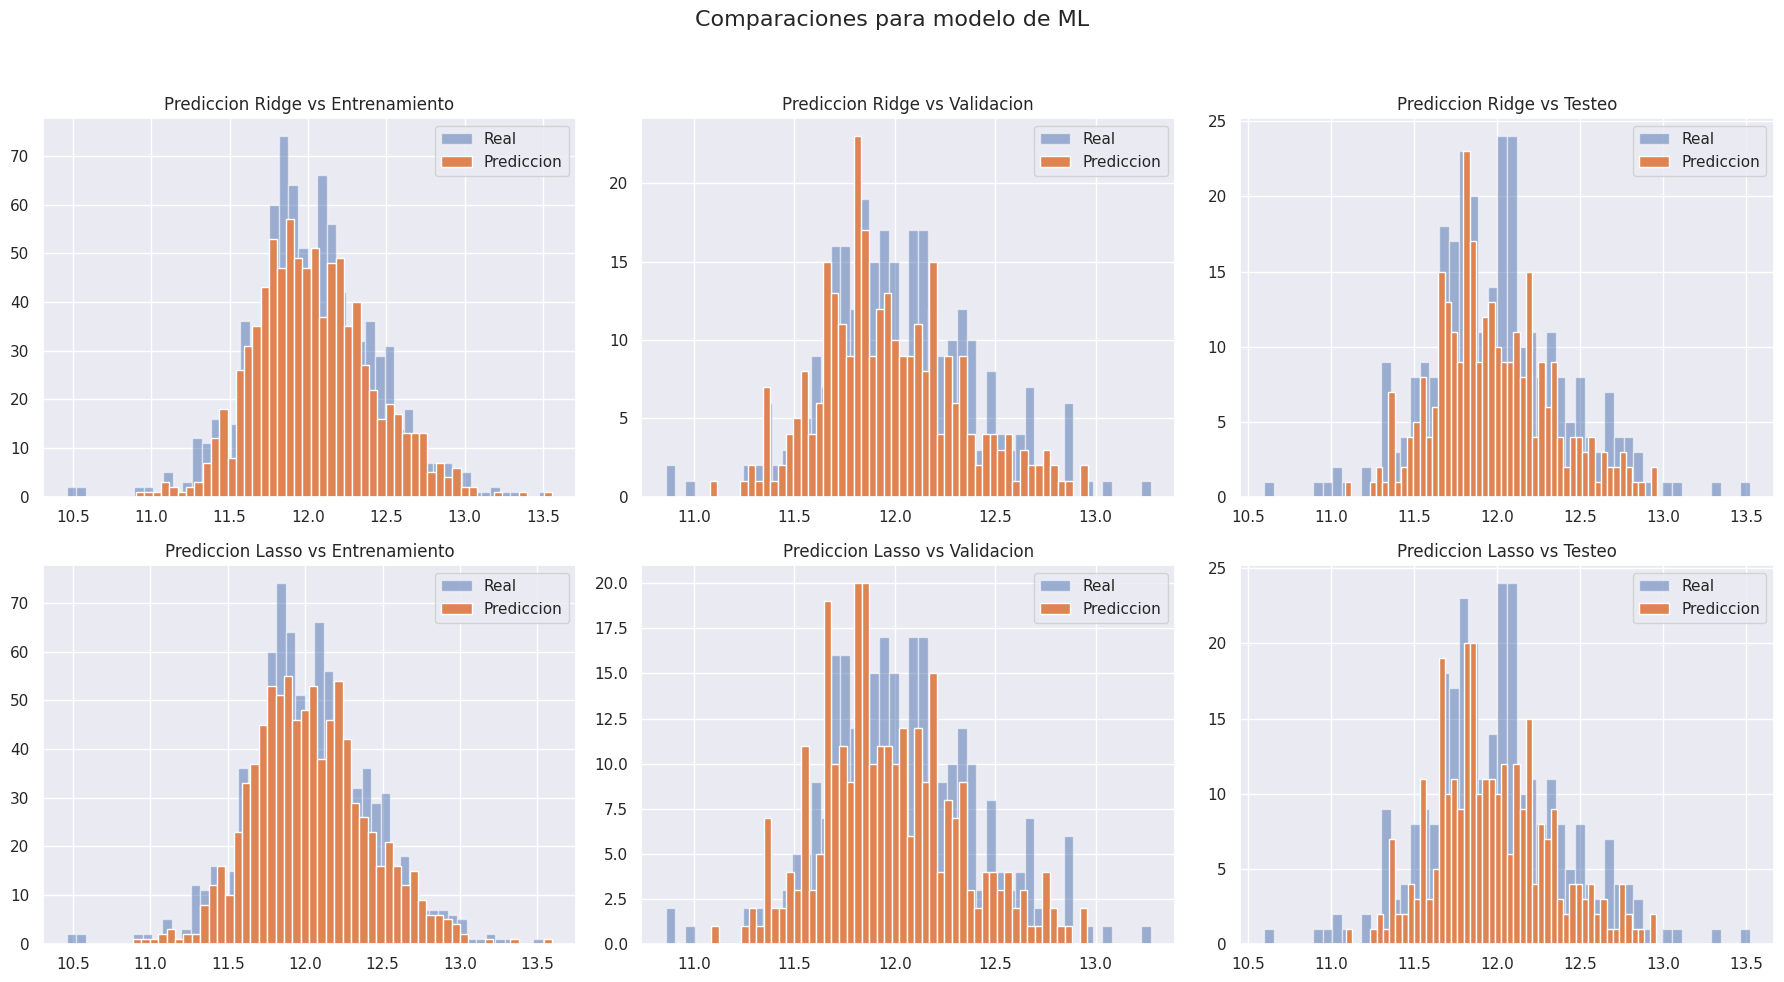

In [ ]:
# @title Graficas comparativas modelo
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

ax[0, 0].hist(y_train, bins=50, alpha=0.5, label="Real")
ax[0, 0].hist(y_pred_ridge_, bins=50, label="Prediccion")
ax[0, 0].set_title("Prediccion Ridge vs Entrenamiento")
ax[0, 0].legend()

ax[0, 1].hist(y_val, bins=50, alpha=0.5, label="Real")
ax[0, 1].hist(y_pred_ridge, bins=50, label="Prediccion")
ax[0, 1].set_title("Prediccion Ridge vs Validacion")
ax[0, 1].legend()

ax[0, 2].hist(y_test, bins=50, alpha=0.5, label="Real")
ax[0, 2].hist(y_pred_ridge, bins=50, label="Prediccion")
ax[0, 2].set_title("Prediccion Ridge vs Testeo")
ax[0, 2].legend()

ax[1, 0].hist(y_train, bins=50, alpha=0.5, label="Real")
ax[1, 0].hist(y_pred_lasso_, bins=50, label="Prediccion")
ax[1, 0].set_title("Prediccion Lasso vs Entrenamiento")
ax[1, 0].legend()

ax[1, 1].hist(y_val, bins=50, alpha=0.5, label="Real")
ax[1, 1].hist(y_pred_lasso, bins=50, label="Prediccion")
ax[1, 1].set_title("Prediccion Lasso vs Validacion")
ax[1, 1].legend()

ax[1, 2].hist(y_test, bins=50, alpha=0.5, label="Real")
ax[1, 2].hist(y_pred_lasso, bins=50, label="Prediccion")
ax[1, 2].set_title("Prediccion Lasso vs Testeo")
ax[1, 2].legend()


fig.suptitle("Comparaciones para modelo de ML", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
coef_ridge = ridge.coef_.tolist()
coef_ridge = [round(elem, 3) for elem in sorted(ridge.coef_.tolist())]
coef_and_vari = pd.DataFrame({"columnas": selected_columns, "coeficientes": coef_ridge})

In [ ]:
coef_and_vari.sort_values(by="coeficientes", ascending=True)

,columnas,coeficientes
0,lotarea,-0.019
1,grlivarea,-0.018
2,1stflrsf,-0.010
3,mssubclass,-0.009
4,overallcond,-0.007
5,bsmtunfsf,-0.006
6,garagearea,-0.003
8,overallqual,-0.002
7,yearbuilt,-0.002
9,bsmtfinsf1,-0.001


#### **A Model with Fewer Features**

Seeing that the Ridge model has a slightly lower score for the test data vs. the prediction compared to Lasso, and observing the coefficients given by Ridge for each of the variables listed above, it can be seen that many of these are zeros, which implies that several features are becoming zero. Would removing these features from the dataset lead to better performance in the Ridge model?

Let's observe:


In [ ]:
# @title Modelo con menos features
%%capture
selected_columns_2 = ["lotarea", "grlivarea", "1stflrsf", "mssubclass", "overallcond",
                    "bsmtunfsf", "garagearea", "yearbuilt", "overallqual", "bsmtfinsf1" ,"group_neighborhood",
                    "group_exterior2nd", "fireplaces", 'landcontour', 'landslope', 'condition1', "bedroomabvgr",
                    'roofstyle', 'roofmatl', 'exterior1st','exterqual', 'extercond', 'foundation',
                    'bsmtqual', 'bsmtexposure','heatingqc', 'centralair', 'electrical',
                    'functional', 'garagequal', 'paveddrive']

X_test = df_test[selected_columns_2]
X_test = Prepare_Data(X_test)
X_train_ = df_train[selected_columns_2]
X_val = Prepare_Data(df_val[selected_columns_2])

ridge = Ridge(alpha=10).fit(X_train_, y_train)

# la prediccionn
y_pred_ridge_ = ridge.predict(X_train_)

# Realizando Hyperparameter Tunning
hyperParameters = {'alpha': np.logspace(-15, 5, num=21)}
ridgeRegressor = GridSearchCV(ridge, hyperParameters, scoring='neg_mean_squared_error', cv=10)
ridgeRegressor.fit(X_train_,y_train)

y_pred_ridge = ridge.intercept_ + X_val.dot(ridge.coef_)

In [ ]:
print("**********Scores y resultados para Regularización de Ridge (Menos Features)**********")
print("Training set score: {:.2f}".format(ridge.score(X_train_, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ridge.score(X_val, y_val)))
print("Best value for lambda : ", ridgeRegressor.best_params_)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_ridge ))}" )

**********Scores y resultados para Regularización de Ridge (Menos Features)**********
Training set score: 0.86
Test set score: 0.86
Validation set score: 0.88
Best value for lambda :  {'alpha': 10.0}
RMSE: 0.13021292535597748


Indeed, the score value for the prediction with the test data increased by 0.01.


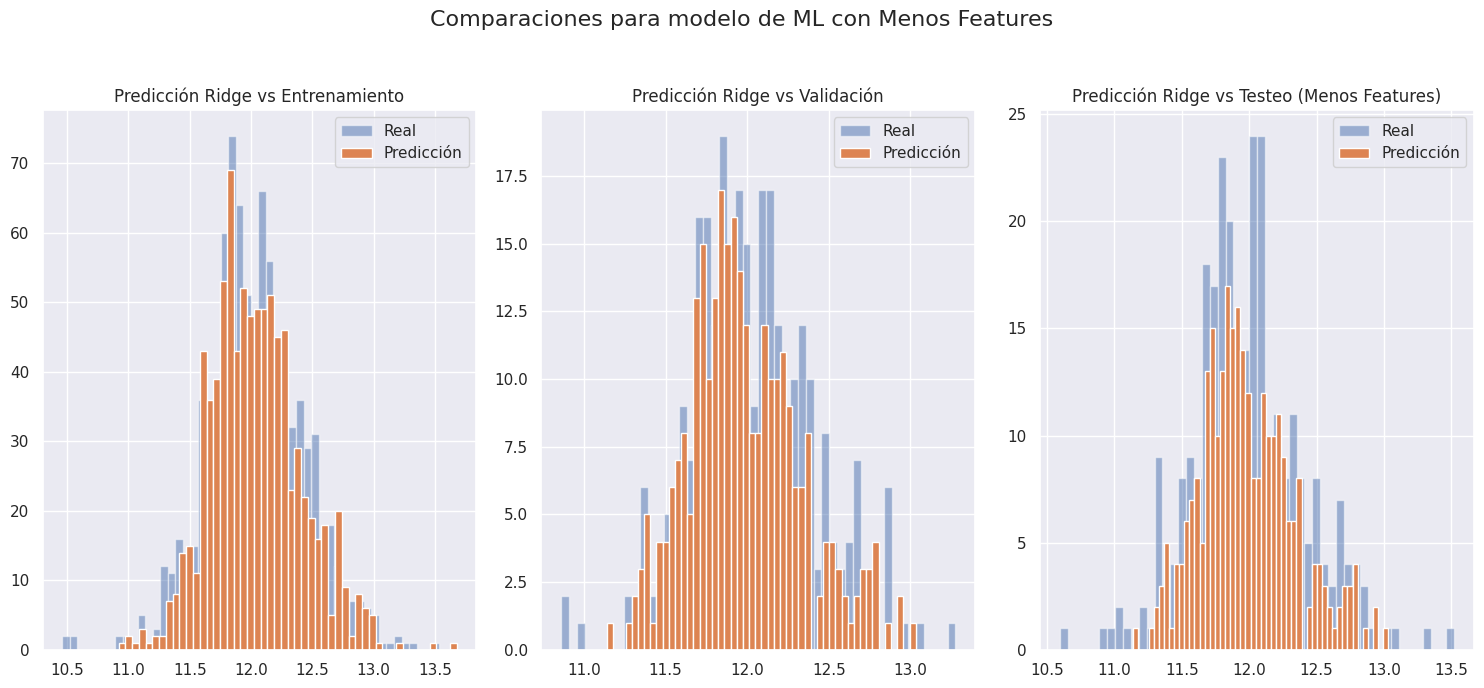

In [ ]:
# @title Gráficas comparativas Modelo con menos Features
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

ax[0].hist(y_train, bins=50, alpha=0.5, label="Real")
ax[0].hist(y_pred_ridge_, bins=50, label="Predicción")
ax[0].set_title("Predicción Ridge vs Entrenamiento")
ax[0].legend()

ax[1].hist(y_val, bins=50, alpha=0.5, label="Real")
ax[1].hist(y_pred_ridge, bins=50, label="Predicción")
ax[1].set_title("Predicción Ridge vs Validación")
ax[1].legend()

ax[2].hist(y_test, bins=50, alpha=0.5, label="Real")
ax[2].hist(y_pred_ridge, bins=50, label="Predicción")
ax[2].set_title("Predicción Ridge vs Testeo (Menos Features)")
ax[2].legend()

fig.suptitle("Comparaciones para modelo de ML con Menos Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

For both Lasso and Ridge models, the scores were the same. The score for the comparison between the prediction and the test data increased by 0.01, reflecting that by removing some noise, the model fit the data much better.

---

## **Conclusions**

* The main conclusion is that **the model using Ridge regularization showed the best results**. The model had a score of 0.87 compared to the training data, 0.85 compared to the test data, and 0.88 with the validation data. Similar values were found for the Lasso model, but when looking at the comparison graphs between the prediction and the different train, test, and validation datasets, we can see that Ridge fits the test data a bit better compared to Lasso. So, if I had to choose a linear model for this dataset, I would use Ridge.

* A model with fewer features provided slightly better precision by removing noise from the model, but it was not significantly different from the results obtained with more features. This is a positive aspect of this approach: even with 11 fewer features out of a total of 43, the model still performs well. So, if we were to think of a larger-scale problem, with many more features, there could be significant optimization :)

* Something interesting about the model was that when the Pearson correlation matrix was performed during the EDA for the numerical variables, we saw that there were variables strongly related to the house price (those that were graphed). However, when mutual information was calculated for the numerical variables, the behavior did not remain the same. That is, the variables that had shown a good correlation with Pearson had a relatively low score. This happens because mutual information looks for relationships between each variable and the target **not only in a linear manner**—it broadens the scope and finds other types of relationships. This implies that the linear regression model might not be the best option for this problem, and using more sophisticated models could yield much better predictions.

